In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt 

In [2]:
class agent():
    
    def __init__(self, env, gamma= 0.7, epsilon= 0.1, learning_rate= 0.05):
        self.gamma= gamma
        self.learning_rate= learning_rate
        self.epsilon = epsilon
        self.q = np.zeros((env.observation_space.n, env.action_space.n))  #q_values
        self.dq = np.zeros((env.observation_space.n, env.action_space.n)) #for double Q learning
        self.env = env
    
    #Epsilon greedy policy
    def e_greedy(self, obs, q):
        num =  q.shape[1]
        prob = (self.epsilon/num) * np.ones(num)    #prob of sub-optimal actions
        best = np.random.choice(np.flatnonzero(np.isclose(q[obs], q[obs].max(), rtol=0.01)))  
        prob[best] = 1 - self.epsilon + (self.epsilon/num)  #prob of optimal actions
        action = np.random.choice(np.arange(num), p=prob)
        return action
    
    #Best action
    def get_best_action(self ,obs, q):
        best_action = np.random.choice(np.flatnonzero(np.isclose(q[obs], q[obs].max(), rtol=0.01)))  
        return best_action 

    #Double Q learning
    def Qlearning_train(self, ep, anneal):
        for i in range(ep):
            if (i+1)%1000==0:  #Exploration annealing
                self.epsilon = max(self.epsilon - anneal, 0.01)
            ep_return = 0
            obs, _= self.env.reset()   #resets the environment
            term=False                 
            power= 0
            while term !=True:         #until episode terminates
                action = self.e_greedy(obs, self.q+ self.dq)
                next_obs, reward, term, _, _ = self.env.step(action) 
                ep_return += (self.gamma**power)*reward    #Discounted return

                #TD update
                choice = np.random.choice(np.arange(2))
                if(choice==0):
                    max_a = self.get_best_action(next_obs, self.q)
                    self.q[obs][action] += self.learning_rate*(reward + self.gamma* self.dq[next_obs][max_a] - self.q[obs][action])

                else:
                    max_a = self.get_best_action(next_obs, self.dq)
                    self.dq[obs][action] += self.learning_rate*(reward + self.gamma* self.q[next_obs][max_a] - self.dq[obs][action])
                    
                obs = next_obs
                power+=1
            if (i + 1) % 100 == 0:  #print only every 100th value. Increase to speed training.
                clear_output(wait=True)
                print(f"Episode {i+1} return: {ep_return}")
        self.env.close()

    #Evaluating trained policy
    def run_policy(self, test_env, loop):
        for i in range(loop):
            obs, _= test_env.reset()
            term= False
            while term !=True:
                test_env.render()
                action = self.get_best_action(obs, self.q + self.dq)
                obs, _, term, _, _ = test_env.step(action)
        test_env.close()

In [3]:
#Training
episodes=10000    #training episodes
exp_anneal= 0.04  #exploration annealing
map = ["FFFG", 
       "FHFH", 
       "SHFH", 
       "FFFF"]
train_env = gym.make('FrozenLake-v1', render_mode= None, desc=map , map_name="4x4", is_slippery=False)
test_agent = agent(train_env, epsilon=0.5)

test_agent.Qlearning_train(episodes, exp_anneal)

Episode 10000 return: 0.24009999999999995


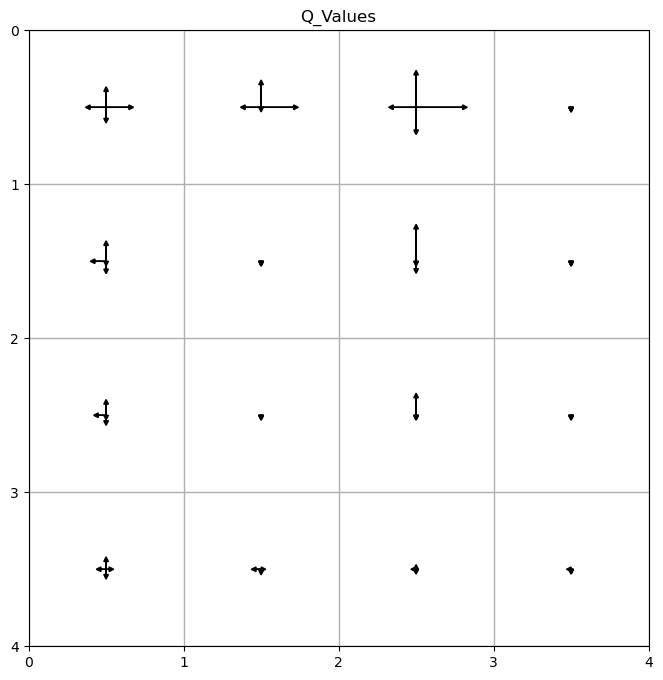

In [5]:
#Visualize the Q table
map_height = 4 
map_width = 4
q_values = test_agent.q + test_agent.dq
q_values= q_values.reshape(map_height, map_width, 4) 
q_values = q_values/ np.max(q_values)   #normalize Q values

fig, axis = plt.subplots(figsize=(8, 8))

axis.set_xlim(0, map_width)
axis.set_ylim(0, map_height)
axis.set_xticks(np.arange(0, map_width+1, 1))
axis.set_yticks(np.arange(0, map_height+1, 1))
axis.grid(True, linewidth=1) 
axis.set_title('Q_Values')

for y in range(map_height):
    for x in range(map_width):
        for action in range(4):
            if action == 0:  # Left
                x_length, y_length = -.3 * q_values[y, x, action], 0
            elif action == 1:  # Down
                x_length, y_length = 0, .3 * q_values[y, x, action]
            elif action == 2:  # Right
                x_length, y_length = .3 * q_values[y, x, action], 0
            elif action == 3:  # Up
                x_length, y_length = 0, -.3 * q_values[y, x, action]
            axis.arrow(x + 0.5, y + 0.5, x_length, y_length, color='black', head_width=0.03, head_length=0.03)

plt.gca().invert_yaxis()
plt.show()

In [6]:
#Replaying the policy
test_env = gym.make('FrozenLake-v1', render_mode= "human", desc=map , map_name="5x5", is_slippery=False)
loop= 2
test_agent.run_policy(test_env, loop)